# pyOpenMS in R

Currently, there are no native wrappers for the OpenMS library in R,
however we can use the "reticulate" package in order to get access to
the full functionality of pyOpenMS in the R programming language.

## Install the "reticulate" R Package

In order to use all pyOpenMS functionalities in R, we suggest to use the
"reticulate" R package.

A thorough documentation is available at:
<https://rstudio.github.io/reticulate/>

``` R
install.packages("reticulate")
```

Installation of pyOpenMS is a requirement as well and it is necessary to
make sure that R is using the same Python environment.

In case R is having trouble to find the correct Python environment, you
can set it by hand as in this example (using miniconda, you will have to
adjust the file path to your system to make this work). You will need to
do this before loading the "reticulate" library:

``` R
Sys.setenv(RETICULATE_PYTHON = "/usr/local/miniconda3/envs/py37/bin/python")
```

Or after loading the "reticulate" library:

``` R
library("reticulate")
use_python("/usr/local/miniconda3/envs/py37/bin/python")
```

## Import pyOpenMS in R

After loading the "reticulate" library you should be able to import
pyOpenMS into R

``` R
library(reticulate)
ropenms=import("pyopenms", convert = FALSE)
```

This should now give you access to all of pyOpenMS in R. Importantly,
the convert option has to be set to FALSE, since type conversions such
as 64bit integers will cause a problem.

You should now be able to interact with the OpenMS library and, for
example, read and write
[mzML](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-mzML)
files:

``` R
library(reticulate)
ropenms=import("pyopenms", convert = FALSE)
exp = ropenms$MSExperiment()
ropenms$MzMLFile()$store("testfile.mzML", exp)
```

which will create an empty
[mzML](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-mzML)
file called <span class="title-ref">testfile.mzML</span>.

## Getting help

Using the "reticulate" R package provides a way to access the pyOpenMS
information about the available functions and methods. We can inspect
individual pyOpenMS objects through the `py_help` function:

``` R
library(reticulate)
ropenms=import("pyopenms", convert = FALSE)
idXML=ropenms$IdXMLFile
py_help(idXML)

Help on class IdXMLFile in module pyopenms.pyopenms_4:

class IdXMLFile(__builtin__.object)
|  Methods defined here:
|
|  __init__(...)
|      Cython signature: void IdXMLFile()
|
|  load(...)
|      Cython signature: void load(String filename, libcpp_vector[ProteinIdentification] & protein_ids, libcpp_vector[PeptideIdentification] & peptide_ids)
[...]
```

Alternatively, the autocompletion functionality of RStudio can be used:

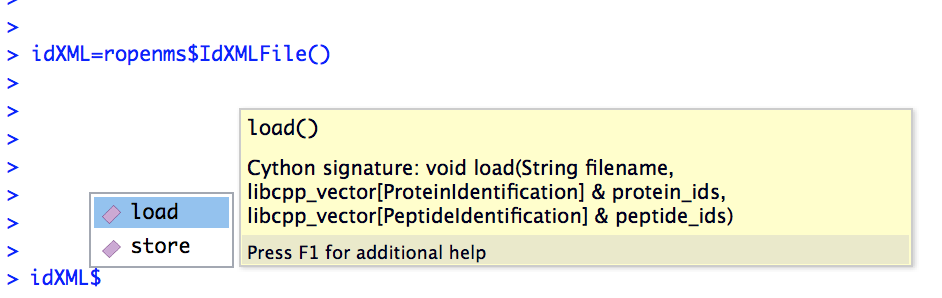

In this case, the help function indicates that the `idXML$load()`
function requires

> -   a filename as string
> -   an empty vector for pyopenms.ProteinIdentification objects
> -   an empty vector for pyopenms.PeptideIdentification objects

In order to read peptide identification data, we can download the [idXML
example
file](https://raw.githubusercontent.com/OpenMS/OpenMS/develop/share/OpenMS/examples/BSA/BSA1_OMSSA.idXML)

Creating an empty R `list()` unfortunately is not equal to the empty
python `list []`.

Therefore in this case we need to use the `reticulate::r_to_py()` and
`reticulate::py_to_r()` functions:

``` R
idXML=ropenms$IdXMLFile()

download.file("https://github.com/OpenMS/OpenMS/raw/master/share/OpenMS/examples/BSA/BSA1_OMSSA.idXML", "BSA1_OMSSA.idXML")

f="BSA1_OMSSA.idXML"
pepids=r_to_py(list())
protids=r_to_py(list())

idXML$load(f, protids, pepids)

pepids=py_to_r(pepids)

pephits=pepids[[1]]$getHits()

pepseq=pephits[[1]]$getSequence()

print(paste0("Sequence: ", pepseq))

[1] "Sequence: SHC(Carbamidomethyl)IAEVEK"
```

## An example use case

### Reading an [mzML](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-mzML) File

pyOpenMS supports a variety of different files through the
implementations in OpenMS. In order to read mass spectrometric data, we
can download the [mzML example
file](https://raw.githubusercontent.com/OpenMS/OpenMS/develop/share/OpenMS/examples/BSA/BSA1.mzML)

``` R
download.file("https://raw.githubusercontent.com/OpenMS/OpenMS/develop/share/OpenMS/examples/BSA/BSA1.mzML", "BSA1.mzML")

library(reticulate)
ropenms=import("pyopenms", convert = FALSE)
mzML=ropenms$MzMLFile()
exp = ropenms$MSExperiment()
mzML$load("BSA1.mzML", exp)
```

which will load the content of the "BSA1.mzML" file into the `exp`
variable of type
[MSExperiment](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MSExperiment.html).
We can now inspect the properties of this object:

``` R
py_help(exp)
Help on MSExperiment object:

class MSExperiment(__builtin__.object)
 |  Methods defined here:
 ...
 |  getNrChromatograms(...)
 |      Cython signature: size_t getNrChromatograms()
 |
 |  getNrSpectra(...)
 |      Cython signature: size_t getNrSpectra()
 |
 ...
```

which indicates that the variable `exp` has (among others) the functions
[MSExperiment.getNrSpectra](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MSExperiment.getNrSpectra.html)
and
[MSExperiment.getNrChromatograms](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MSExperiment.getNrChromatograms.html).
We can now try one of these functions:

``` R
exp$getNrSpectra()
1684
```

and indeed we see that we get information about the underlying MS data.
We can iterate through the spectra as follows:

### Visualize spectra

You can easily visualise ms1 level precursor maps:

``` R
library(ggplot2)

spectra = py_to_r(exp$getSpectra())

peaks_df=c()
for (i in spectra) {
  if (i$getMSLevel()==1){
    peaks=do.call("cbind", i$get_peaks())
    rt=i$getRT()
    peaks_df=rbind(peaks_df,cbind(peaks,rt))
  }
}

peaks_df=data.frame(peaks_df)    
colnames(peaks_df)=c('MZ','Intensity','RT')
peaks_df$Intensity=log10(peaks_df$Intensity)

ggplot(peaks_df, aes(x=RT, y=MZ) ) +
geom_point(size=1, aes(colour = Intensity), alpha=0.25) +
theme_minimal() +
scale_colour_gradient(low = "blue", high = "yellow")
```

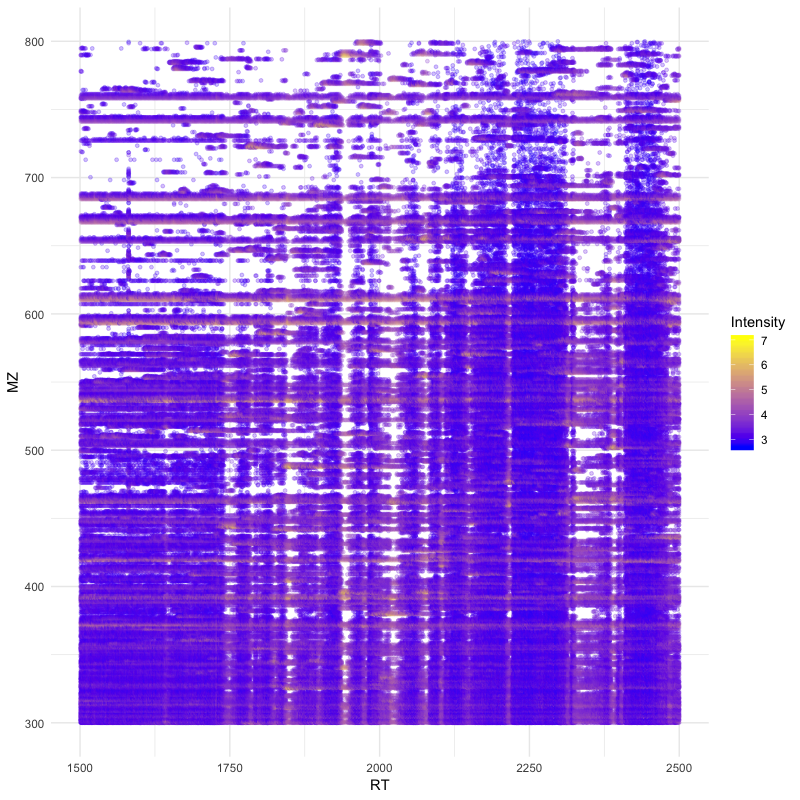

Or visualize a particular ms2 spectrum:

``` R
library(ggplot2)

spectra = py_to_r(exp$getSpectra())

# Collect all MS2 peak data in a list
peaks_ms2=list()
for (i in spectra) {
  if (i$getMSLevel()==2){
    peaks=do.call("cbind",i$get_peaks())
    peaks_ms2[[i$getNativeID()]]=data.frame(peaks)
  }
}

ms2_spectrum=peaks_ms2[["spectrum=3529"]]
colnames(ms2_spectrum)=c("MZ","Intensity")

ggplot(ms2_spectrum, aes(x=MZ, y=Intensity)) +
geom_segment( aes(x=MZ, xend=MZ, y=0, yend=Intensity)) +
theme_minimal()
```

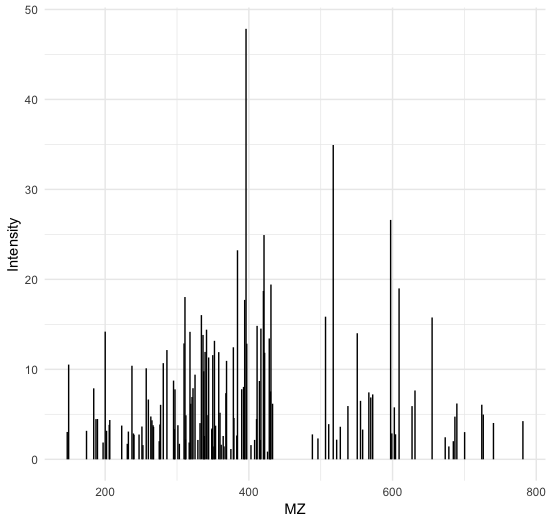

Alternatively, we could also have used `apply` to obtain the peak data,
which is more idiomatic way of doing things for the R programming
language:

``` R
ms1 = sapply(spectra, function(x) x$getMSLevel()==1)
peaks = sapply(spectra[ms1], function(x) cbind(do.call("cbind", x$get_peaks()),x$getRT()))
peaks = data.frame( do.call("rbind", peaks) )

ms2 = spectra[!ms1][[1]]$get_peaks()
ms2_spectrum = data.frame( do.call("cbind", ms2) )
```

### Iteration

Iterating over pyOpenMS objects is not equal to iterating over R vectors
or lists. Note that for many applications, there is a more efficient way
to access data (such as
[MSSpectrum.get_peaks](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MSSpectrum.get_peaks.html)
instead of iterating over individual peaks).

Therefore we can not directly apply the usual functions such as
`apply()` and have to use `reticulate::iterate()` instead:

``` R
spectrum = ropenms$MSSpectrum()
mz = seq(1500, 500, -100)
i = seq(10, 2000, length.out = length(mz))
spectrum$set_peaks(list(mz, i))

iterate(spectrum, function(x) {print(paste0("M/z :" , x$getMZ(), " Intensity: ", x$getIntensity()))})

[1] "M/z :1500.0 Intensity: 10.0"
[1] "M/z :1400.0 Intensity: 209.0"
[1] "M/z :1300.0 Intensity: 408.0"
[1] "M/z :1200.0 Intensity: 607.0"
[1] "M/z :1100.0 Intensity: 806.0"
[1] "M/z :1000.0 Intensity: 1005.0"
[1] "M/z :900.0 Intensity: 1204.0"
[1] "M/z :800.0 Intensity: 1403.0"
[1] "M/z :700.0 Intensity: 1602.0"
[1] "M/z :600.0 Intensity: 1801.0"
[1] "M/z :500.0 Intensity: 2000.0"
```

or we can use a for-loop (note that we use zero-based indices as custom
in Python):

``` R
for (i in seq(0,py_to_r(spectrum$size())-1)) {
      print(spectrum[i]$getMZ())
      print(spectrum[i]$getIntensity())
}
```